# Train custom scAdam model

In [39]:
import scanpy as sc
import scparadise
import os
import numpy as np
import pandas as pd
import warnings 
warnings.simplefilter('ignore')
sc.set_figure_params(dpi = 150)

In [2]:
os.chdir('/mnt/c/Users/vadim/scRNA/scParadise/scripts_package/')

## Recommendations about training dataset 
We recommend shifted logarithm data normalization method: <br>
sc.pp.normalize_total(adata, target_sum=None) <br>
sc.pp.log1p(adata) <br>
But you can use any other method of data normalzation (Use the same normalization method for test dataset) <br>
Training dataset sould contain all genes that you want to use for model training in adata_train.X <br>
We recommend to remove all non-marker genes from adata_train.X (removeing of such useless genes increase performance and model quality metrics)

In [57]:
# Load prepared for training anndata object
adata = sc.read_h5ad('adata.h5ad')

In [58]:
# Create adata_test dataset (we used 2 samples for training dataset)
adata_test = adata[adata.obs['orig.ident'].isin(['P8_7', 'P5_3'])].copy()

In [59]:
# Create adata_train dataset
adata_train = adata[adata.obs.drop(adata_test.obs_names).index].copy()

## Balanced training
We recommend balance dataset based on most detailed annotation level (celltype_l3 in this case). <br>
Balancing the training dataset increases the sensitivity (balanced accuracy), f1-score and geometric mean of the model but leads to slightly decrease in precision

In [60]:
# Balance dataset based on most detailed annotation level
adata_balanced = scparadise.scnoah.balance(adata_train, 
                                           sample = 'orig.ident',
                                           celltype_l1 = 'celltype_l1',
                                           celltype_l2 = 'celltype_l2',
                                           celltype_l3 = 'celltype_l3')

Successfully undersampled cell types: CD14 Mono, CD4 T Naive, NK, CD4 TCM, CD8 T Naive, CD8 TEM, CD16 Mono, B naive kappa

Successfully oversampled cell types: CD4 TEM, gdT, B naive lambda, CD8 TCM, MAIT, Treg, cDC2, Platelet, B memory kappa, CD4 CTL, B intermediate lambda, B memory lambda, B intermediate kappa, NK_CD56bright, pDC, NK Prolif, Plasmablast, dnT, HSPC, cDC1, ILC, CD4 T Prolif, CD8 T Prolif, ASDC


In [61]:
# Train scadam model using adata_balanced dataset
scparadise.scadam.train(adata_balanced,
                        path = '', # path to save model
                        model_name = 'model_scadam', # folder name with model
                        celltype_l1 = 'celltype_l1', # First (less detailed) annotation level
                        celltype_l2 = 'celltype_l2', # Second annotation level
                        celltype_l3 = 'celltype_l3', # Third (most detailed) annotation level
                        eval_metric = ['logloss','balanced_accuracy','accuracy'])

Successfully saved genes names for training model

Successfully saved dictionary of dataset annotations

Train dataset contains: 131443 cells, it is 90.0 % of input dataset
Test dataset contains: 14605 cells, it is 10.0 % of input dataset

Accelerator: cuda
Start training
epoch 0  | loss: 1.53669 | train_logloss: 0.71031 | train_balanced_accuracy: 0.72037 | train_accuracy: 0.7276  | valid_logloss: 0.71215 | valid_balanced_accuracy: 0.71876 | valid_accuracy: 0.72617 |  0:00:05s
epoch 1  | loss: 0.69599 | train_logloss: 0.34463 | train_balanced_accuracy: 0.88309 | train_accuracy: 0.87924 | valid_logloss: 0.34728 | valid_balanced_accuracy: 0.88326 | valid_accuracy: 0.88    |  0:00:10s
epoch 2  | loss: 0.5015  | train_logloss: 0.23545 | train_balanced_accuracy: 0.91432 | train_accuracy: 0.91387 | valid_logloss: 0.24268 | valid_balanced_accuracy: 0.91254 | valid_accuracy: 0.91231 |  0:00:16s
epoch 3  | loss: 0.43863 | train_logloss: 0.19847 | train_balanced_accuracy: 0.93028 | train_accurac

In [62]:
# Predict cell types using trained model
adata_test = scparadise.scadam.predict(adata_test, 
                                       path_model = 'model_scadam/')

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully added predicted celltype_l2 and cell type probabilities
Successfully added predicted celltype_l3 and cell type probabilities


In [63]:
# Order cell type colors
celltype_list = ['celltype_l1','celltype_l2','celltype_l3']
for i in celltype_list:
    celltype = np.unique(adata_test.obs[i]).tolist()
    adata_test.obs[i] = pd.Categorical(
        values=adata_test.obs[i], categories=celltype, ordered=True
    )
    adata_test.obs['pred_' + i] = pd.Categorical(
        values=adata_test.obs['pred_' + i], categories=celltype, ordered=True
    )

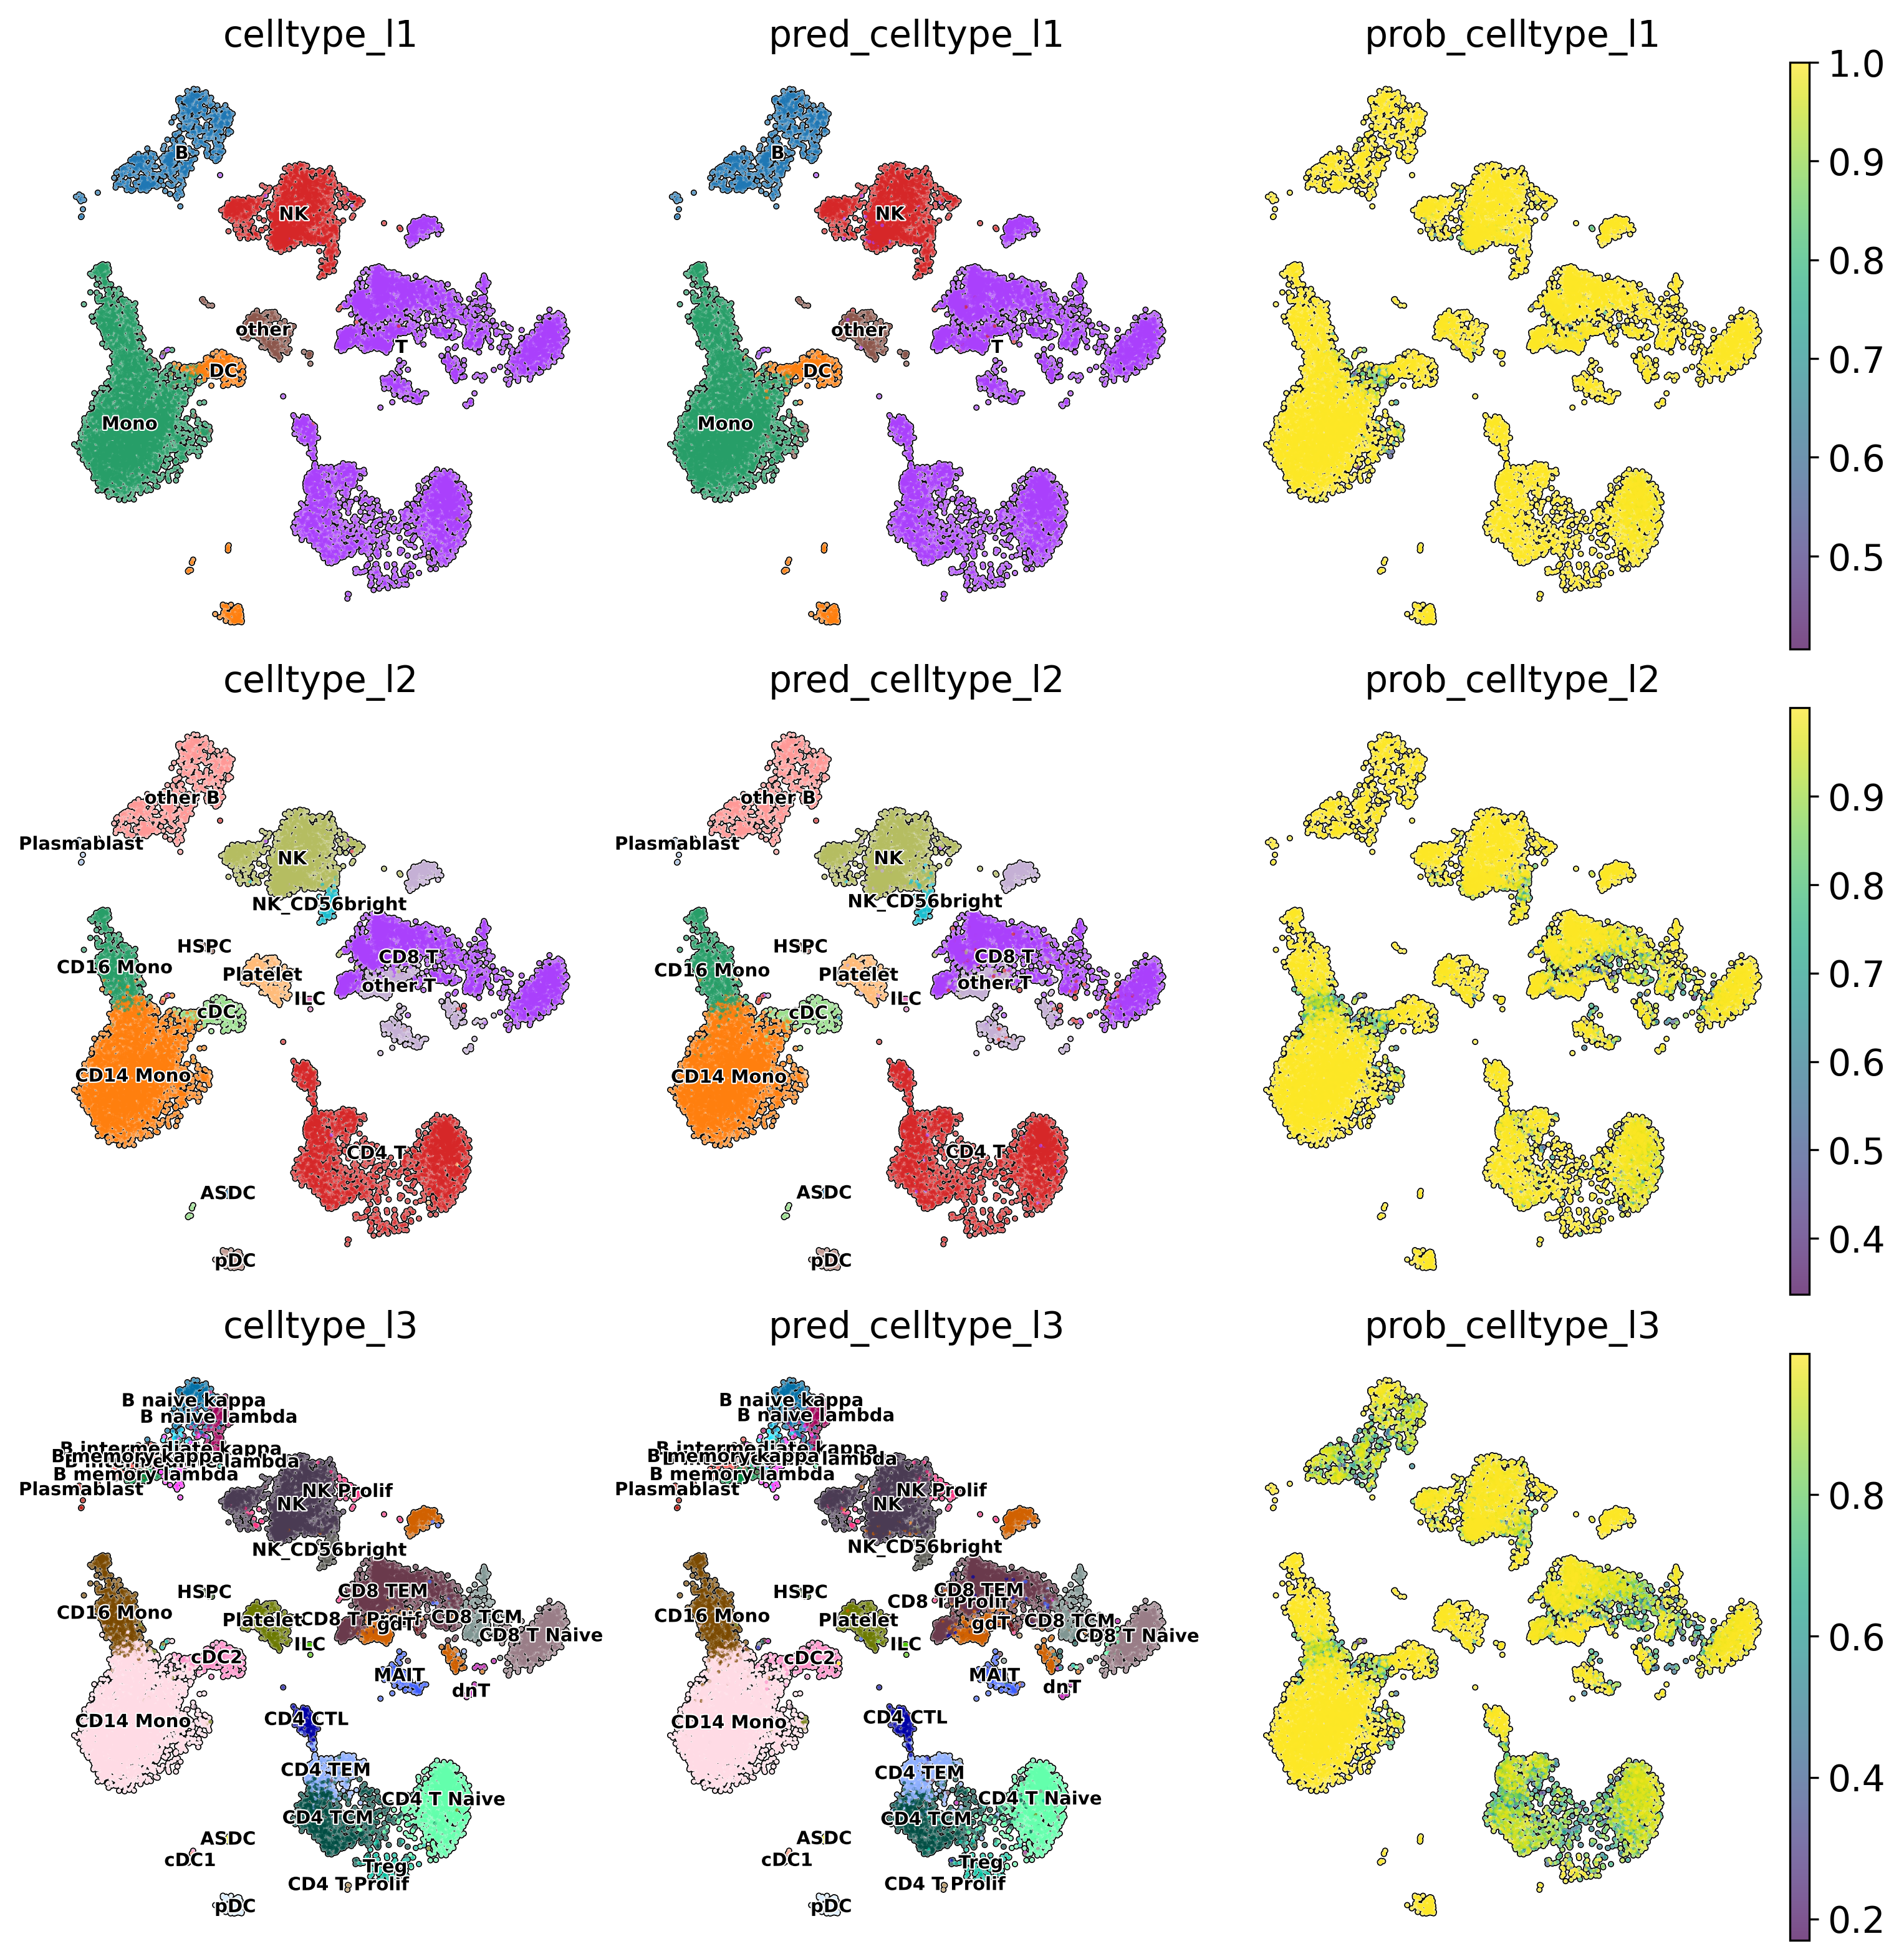

In [64]:
# Visualise predicted cell types levels and prediction probabilities
sc.pl.embedding(adata_test, 
                color=[
                    'celltype_l1',
                    'pred_celltype_l1',
                    'prob_celltype_l1',
                    'celltype_l2',
                    'pred_celltype_l2',
                    'prob_celltype_l2',
                    'celltype_l3',
                    'pred_celltype_l3',
                    'prob_celltype_l3'
                ],
                basis = 'X_umap',
                frameon = False,
                add_outline = True,
                legend_loc = 'on data',
                legend_fontsize = 7,
                legend_fontoutline = 1,
                ncols=3,
                wspace = 0, 
                hspace = 0.1)

In [ ]:
# Save anndata with predicted annotations
adata_test.write_h5ad('adata_test.h5ad')

## Check model quality

In [65]:
# First annotation level (celltype_l1)
df_l1 = scparadise.scnoah.report_classif_full(adata_test,
                                              celltype='celltype_l1',
                                              pred_celltype='pred_celltype_l1',
                                              ndigits=3)
df_l1

precision recall/sensitivity specificity f1-score  \
B                      1.000                1.0         1.0      1.0   
DC                     0.898                1.0       0.997    0.946   
Mono                   0.999              0.988       0.999    0.994   
NK                     0.993              0.988       0.999    0.991   
T                      0.994              0.998       0.996    0.996   
other                  0.960              0.958       0.999    0.959   
macro avg              0.974              0.989       0.998    0.981   
weighted avg           0.992              0.992       0.998    0.992   
Accuracy               0.992                                           
Balanced accuracy      0.989                                           

                  geometric mean index balanced accuracy number of cells  
B                            1.0                     1.0             763  
DC                         0.998                   0.997             386  
Mono                       0.994                   0.986            5042  
NK                         0.994                   0.986            2225  
T                          0.997                   0.993            6187  
other                      0.978                   0.953             380  
macro avg                  0.993                   0.986                  
weighted avg               0.995                   0.989                  
Accuracy                                                                  
Balanced accuracy

In [66]:
# Second annotation level (celltype_l2)
df_l2 = scparadise.scnoah.report_classif_full(adata_test,
                                              celltype='celltype_l2',
                                              pred_celltype='pred_celltype_l2',
                                              ndigits=3)
df_l2

precision recall/sensitivity specificity f1-score  \
ASDC                   0.857              0.857         1.0    0.857   
CD14 Mono              0.996              0.969       0.998    0.982   
CD16 Mono              0.883              0.976       0.994    0.927   
CD4 T                  0.971              0.989       0.994     0.98   
CD8 T                  0.981              0.948       0.996    0.964   
HSPC                   1.000                1.0         1.0      1.0   
ILC                    0.944                1.0         1.0    0.971   
NK                     0.986              0.982       0.998    0.984   
NK_CD56bright          0.828              0.911       0.999    0.867   
Plasmablast            1.000                1.0         1.0      1.0   
Platelet               0.974              0.958       0.999    0.966   
cDC                    0.868              0.993       0.997    0.926   
other B                1.000                1.0         1.0      1.0   
other T                0.864              0.929       0.992    0.895   
pDC                    0.990                1.0         1.0    0.995   
macro avg              0.943              0.967       0.998    0.954   
weighted avg           0.971               0.97       0.997     0.97   
Accuracy               0.970                                           
Balanced accuracy      0.967                                           

                  geometric mean index balanced accuracy number of cells  
ASDC                       0.926                   0.845               7  
CD14 Mono                  0.983                   0.964            4379  
CD16 Mono                  0.985                   0.968             663  
CD4 T                      0.991                   0.982            2511  
CD8 T                      0.972                    0.94            2862  
HSPC                         1.0                     1.0               6  
ILC                          1.0                     1.0              17  
NK                          0.99                   0.978            2146  
NK_CD56bright              0.954                   0.902              79  
Plasmablast                  1.0                     1.0              11  
Platelet                   0.978                   0.953             357  
cDC                        0.995                    0.99             277  
other B                      1.0                     1.0             752  
other T                     0.96                   0.915             814  
pDC                          1.0                     1.0             102  
macro avg                  0.982                   0.963                  
weighted avg               0.983                   0.964                  
Accuracy                                                                  
Balanced accuracy

In [67]:
# Third annotation level (celltype_l3)
df_l3 = scparadise.scnoah.report_classif_full(adata_test,
                                              celltype='celltype_l3',
                                              pred_celltype='pred_celltype_l3',
                                              ndigits=3)
df_l3

precision recall/sensitivity specificity f1-score  \
ASDC                       0.857              0.857         1.0    0.857   
B intermediate kappa       0.785              0.913       0.998    0.844   
B intermediate lambda      0.812              0.812       0.999    0.812   
B memory kappa             0.947              0.864         1.0    0.904   
B memory lambda            0.842              0.934       0.999    0.885   
B naive kappa              0.868              0.864       0.998    0.866   
B naive lambda             0.863              0.785       0.999    0.822   
CD14 Mono                  0.996              0.969       0.998    0.982   
CD16 Mono                  0.883              0.976       0.994    0.927   
CD4 CTL                    0.745              0.994       0.996    0.852   
CD4 T Naive                0.960               0.95       0.997    0.955   
CD4 T Prolif               0.600               0.75         1.0    0.667   
CD4 TCM                    0.898              0.804       0.995    0.848   
CD4 TEM                    0.762              0.882       0.993    0.818   
CD8 T Naive                0.966              0.944       0.998    0.955   
CD8 T Prolif               0.640              0.842       0.999    0.727   
CD8 TCM                    0.821              0.919       0.997    0.867   
CD8 TEM                    0.974              0.926       0.996    0.949   
HSPC                       1.000                1.0         1.0      1.0   
ILC                        0.944                1.0         1.0    0.971   
MAIT                       0.914              0.886       0.999      0.9   
NK                         0.989              0.974       0.998    0.981   
NK Prolif                  0.806              0.949       0.999    0.872   
NK_CD56bright              0.839              0.924       0.999     0.88   
Plasmablast                1.000                1.0         1.0      1.0   
Platelet                   0.974              0.955       0.999    0.965   
Treg                       0.716              0.808       0.998    0.759   
cDC1                       0.857                1.0         1.0    0.923   
cDC2                       0.873              0.989       0.997    0.927   
dnT                        0.450              0.643       0.999    0.529   
gdT                        0.868              0.943       0.993    0.904   
pDC                        0.990                1.0         1.0    0.995   
macro avg                  0.857              0.908       0.998     0.88   
weighted avg               0.946              0.942       0.997    0.943   
Accuracy                   0.942                                           
Balanced accuracy          0.908                                           

                      geometric mean index balanced accuracy number of cells  
ASDC                           0.926                   0.845               7  
B intermediate kappa           0.955                   0.904              92  
B intermediate lambda          0.901                   0.797              80  
B memory kappa                 0.929                   0.852             125  
B memory lambda                0.966                   0.927              91  
B naive kappa                  0.928                    0.85             220  
B naive lambda                 0.885                   0.767             144  
CD14 Mono                      0.984                   0.965            4379  
CD16 Mono                      0.985                   0.968             663  
CD4 CTL                        0.995                    0.99             165  
CD4 T Naive                    0.973                   0.943            1149  
CD4 T Prolif                   0.866                   0.731               4  
CD4 TCM                        0.895                   0.785             724  
CD4 TEM                        0.936                   0.866             391  
CD8 T Naive              

## Imbalanced training
Use 'balanced_accuracy' as evaluation metric in case of imbalanced learning

In [68]:
# Train scadam model using adata_balanced dataset
scparadise.scadam.train(adata_train,
                        path='', # path to save model
                        model_name='model_scadam_imbalanced', # folder name with model
                        celltype_l1='celltype_l1', # First (less detailed) annotation level
                        celltype_l2='celltype_l2', # Second annotation level
                        celltype_l3='celltype_l3', # Third (most detailed) annotation level
                        eval_metric=['logloss','accuracy','balanced_accuracy']) # If you are using an imbalanced training dataset, we recommend using balance_accuracy for early stopping

Successfully saved genes names for training model

Successfully saved dictionary of dataset annotations

Train dataset contains: 131424 cells, it is 90.0 % of input dataset
Test dataset contains: 14603 cells, it is 10.0 % of input dataset

Accelerator: cuda
Start training
epoch 0  | loss: 1.13764 | train_logloss: 0.4282  | train_accuracy: 0.84802 | train_balanced_accuracy: 0.58284 | valid_logloss: 0.42548 | valid_accuracy: 0.84734 | valid_balanced_accuracy: 0.58219 |  0:00:05s
epoch 1  | loss: 0.41953 | train_logloss: 0.22774 | train_accuracy: 0.92309 | train_balanced_accuracy: 0.73985 | valid_logloss: 0.23064 | valid_accuracy: 0.92175 | valid_balanced_accuracy: 0.74407 |  0:00:11s
epoch 2  | loss: 0.33237 | train_logloss: 0.17547 | train_accuracy: 0.94138 | train_balanced_accuracy: 0.81041 | valid_logloss: 0.17589 | valid_accuracy: 0.93965 | valid_balanced_accuracy: 0.81771 |  0:00:16s
epoch 3  | loss: 0.28983 | train_logloss: 0.13802 | train_accuracy: 0.95213 | train_balanced_accurac

In [70]:
# Predict cell types using trained model
adata_test = scparadise.scadam.predict(adata_test, 
                                       path_model = 'model_scadam_imbalanced')

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully added predicted celltype_l2 and cell type probabilities
Successfully added predicted celltype_l3 and cell type probabilities


In [71]:
# Order cell type colors
celltype_list = ['celltype_l1','celltype_l2','celltype_l3']
for i in celltype_list:
    celltype = np.unique(adata_test.obs[i]).tolist()
    adata_test.obs[i] = pd.Categorical(
        values=adata_test.obs[i], categories=celltype, ordered=True
    )
    adata_test.obs['pred_' + i] = pd.Categorical(
        values=adata_test.obs['pred_' + i], categories=celltype, ordered=True
    )

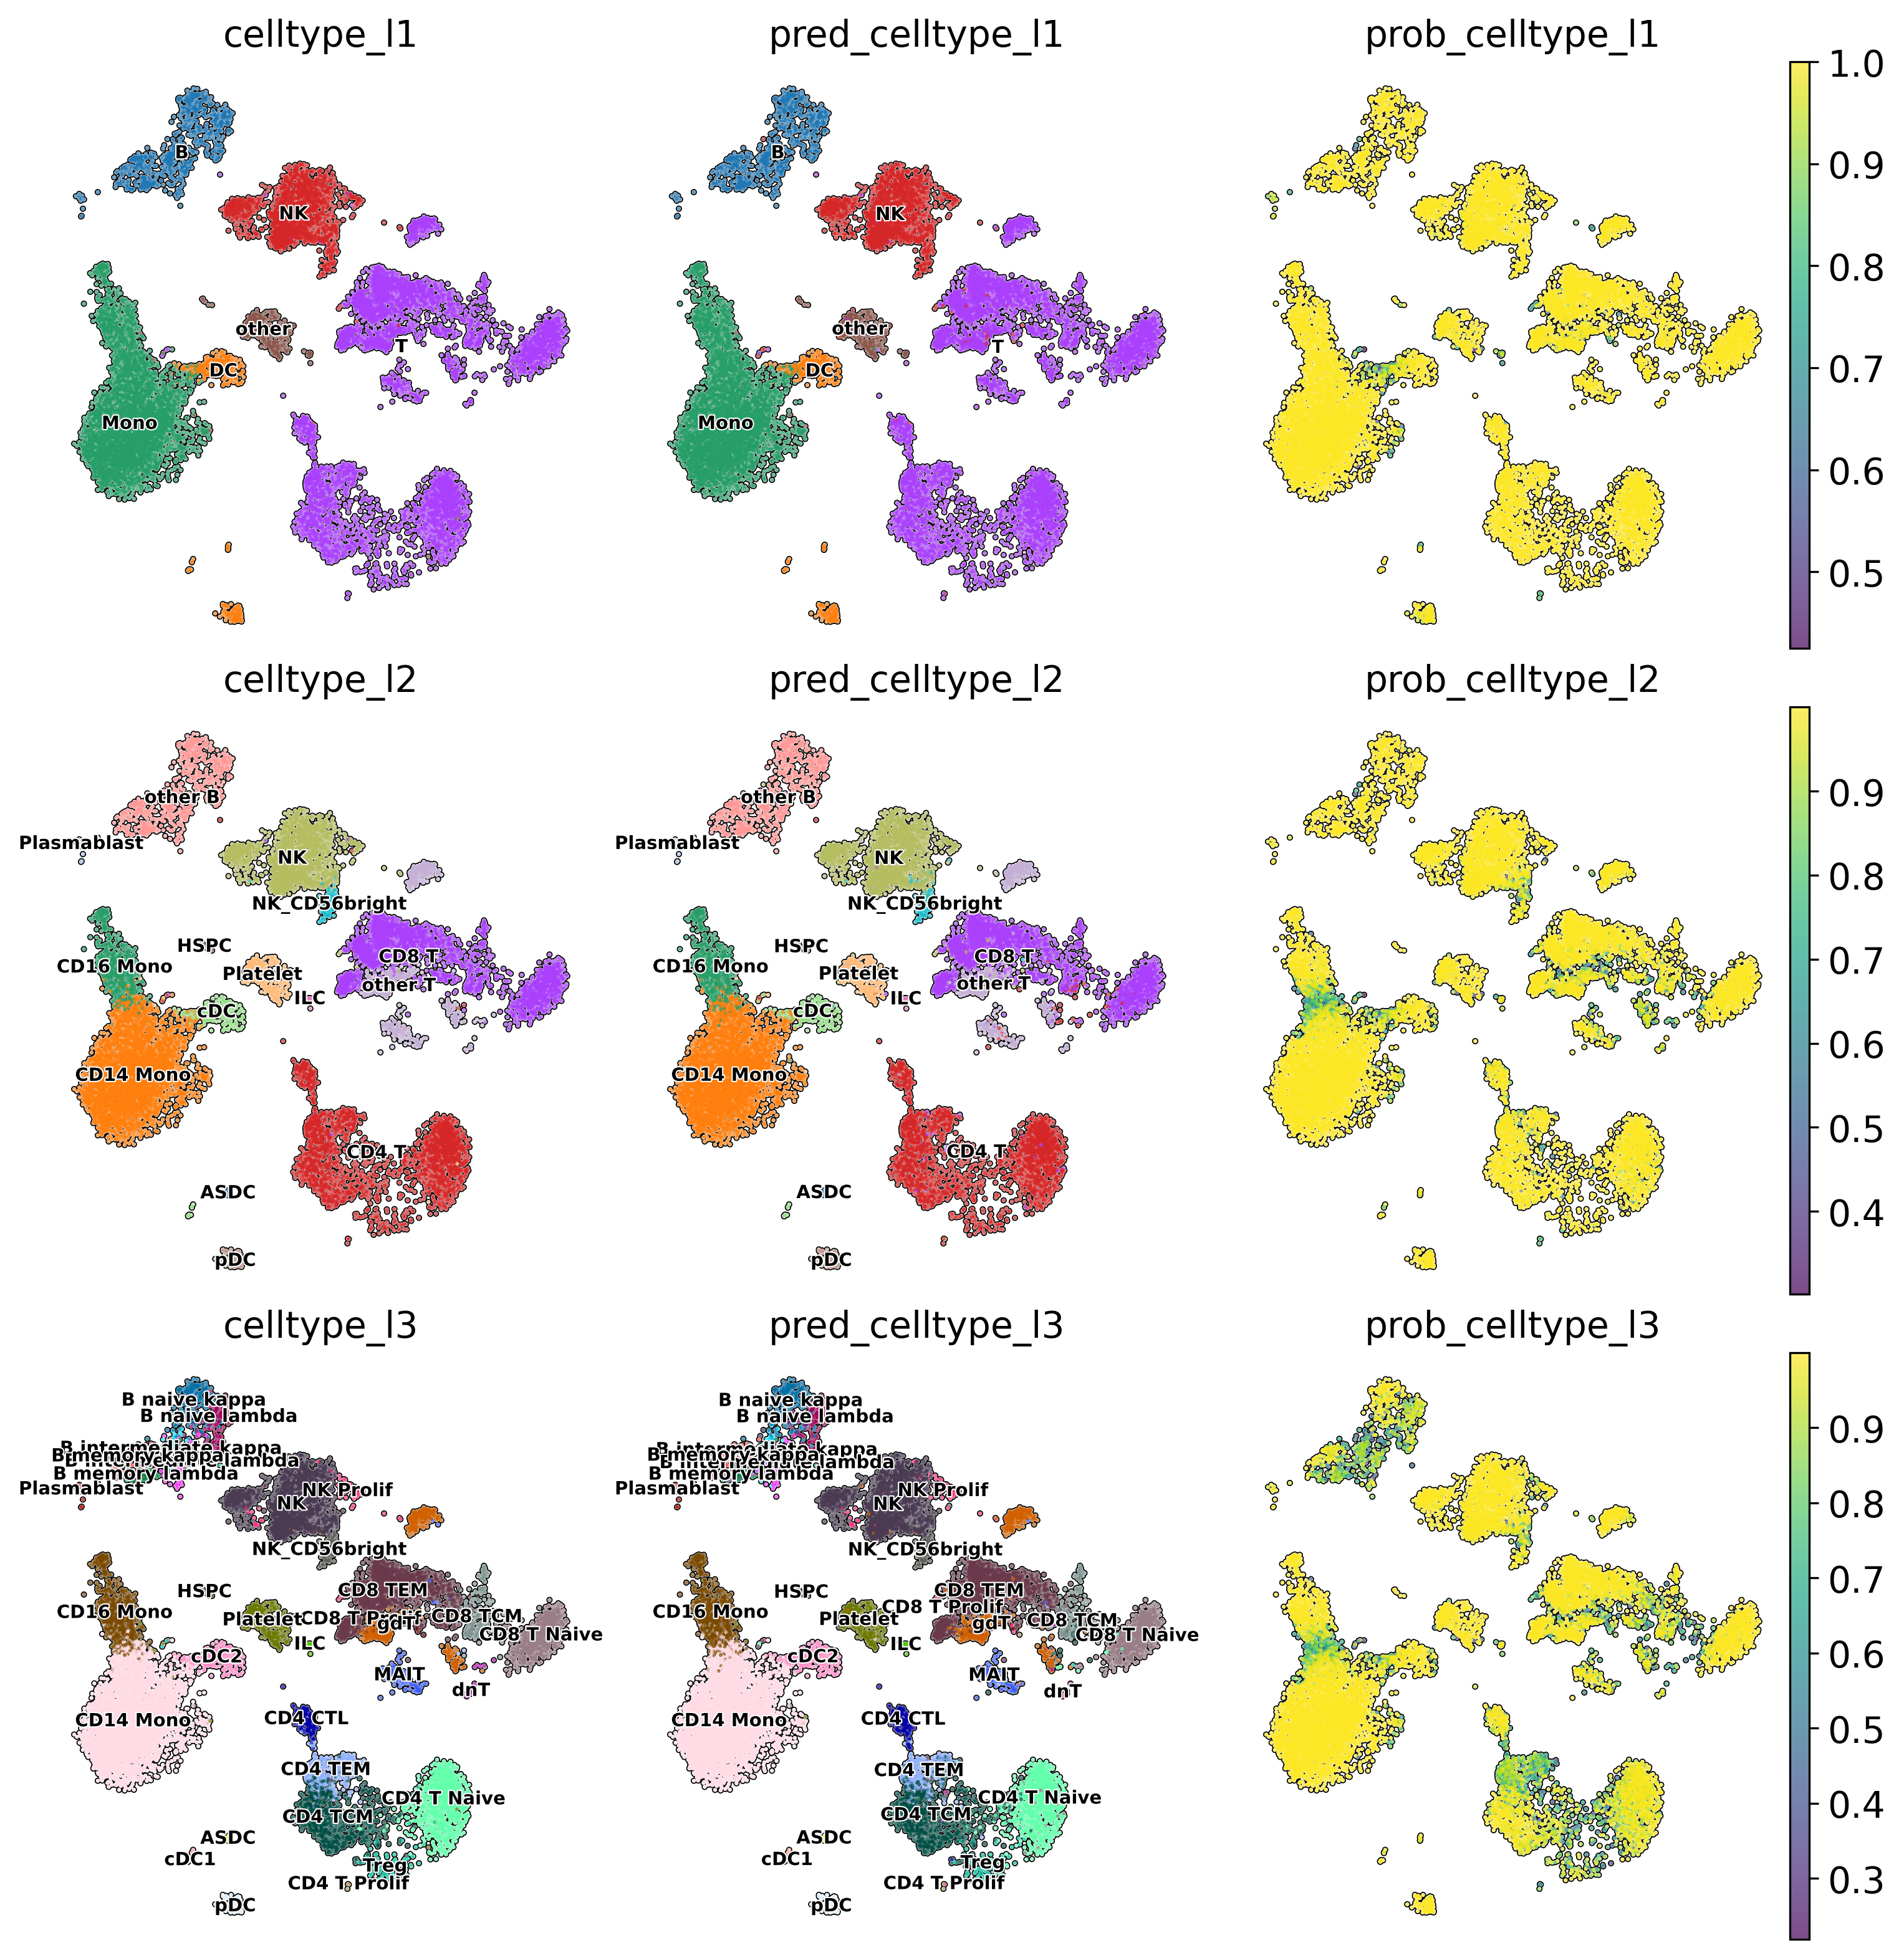

In [72]:
# Visualise predicted cell types levels and prediction probabilities
sc.pl.embedding(adata_test, 
                color=[
                    'celltype_l1',
                    'pred_celltype_l1',
                    'prob_celltype_l1',
                    'celltype_l2',
                    'pred_celltype_l2',
                    'prob_celltype_l2',
                    'celltype_l3',
                    'pred_celltype_l3',
                    'prob_celltype_l3'
                ],
                basis = 'X_umap',
                frameon = False,
                add_outline = True,
                legend_loc = 'on data',
                legend_fontsize = 7,
                legend_fontoutline = 1,
                ncols=3,
                wspace = 0, 
                hspace = 0.1)

## Check model quality

In [73]:
# First annotation level (celltype_l1)
df_l1 = scparadise.scnoah.report_classif_full(adata_test,
                                              celltype='celltype_l1',
                                              pred_celltype='pred_celltype_l1')
df_l1

precision recall/sensitivity specificity f1-score  \
B                     1.0000             0.9987         1.0   0.9993   
DC                    0.9791             0.9689      0.9995    0.974   
Mono                  0.9962             0.9976      0.9981   0.9969   
NK                    0.9801             0.9964      0.9965   0.9882   
T                     0.9969             0.9934      0.9978   0.9951   
other                 0.9945               0.95      0.9999   0.9717   
macro avg             0.9911             0.9842      0.9986   0.9875   
weighted avg          0.9938             0.9938      0.9979   0.9938   
Accuracy              0.9938                                           
Balanced accuracy     0.9842                                           

                  geometric mean index balanced accuracy number of cells  
B                         0.9993                  0.9986             763  
DC                        0.9841                  0.9654             386  
Mono                      0.9979                  0.9957            5042  
NK                        0.9964                  0.9929            2225  
T                         0.9956                  0.9908            6187  
other                     0.9746                  0.9451             380  
macro avg                 0.9913                  0.9814                  
weighted avg              0.9958                  0.9913                  
Accuracy                                                                  
Balanced accuracy

In [74]:
# Second annotation level (celltype_l2)
df_l2 = scparadise.scnoah.report_classif_full(adata_test,
                                              celltype='celltype_l2',
                                              pred_celltype='pred_celltype_l2')
df_l2

precision recall/sensitivity specificity f1-score  \
ASDC                  0.8750                1.0      0.9999   0.9333   
CD14 Mono             0.9877             0.9897      0.9949   0.9887   
CD16 Mono             0.9515             0.9472      0.9978   0.9494   
CD4 T                 0.9787             0.9861      0.9957   0.9823   
CD8 T                 0.9739             0.9654      0.9939   0.9696   
HSPC                  0.8571                1.0      0.9999   0.9231   
ILC                   1.0000             0.9412         1.0   0.9697   
NK                    0.9761             0.9879      0.9959   0.9819   
NK_CD56bright         0.8193             0.8608       0.999   0.8395   
Plasmablast           1.0000                1.0         1.0      1.0   
Platelet              0.9912             0.9468      0.9998   0.9685   
cDC                   0.9707             0.9567      0.9995   0.9636   
other B               1.0000             0.9987         1.0   0.9993   
other T               0.9230             0.9128      0.9956   0.9179   
pDC                   1.0000             0.9902         1.0   0.9951   
macro avg             0.9536             0.9656      0.9981   0.9588   
weighted avg          0.9763             0.9762      0.9957   0.9762   
Accuracy              0.9762                                           
Balanced accuracy     0.9656                                           

                  geometric mean index balanced accuracy number of cells  
ASDC                         1.0                  0.9999               7  
CD14 Mono                 0.9923                  0.9842            4379  
CD16 Mono                 0.9722                  0.9403             663  
CD4 T                     0.9909                  0.9808            2511  
CD8 T                     0.9795                  0.9568            2862  
HSPC                         1.0                  0.9999               6  
ILC                       0.9701                  0.9356              17  
NK                        0.9919                  0.9831            2146  
NK_CD56bright             0.9273                   0.848              79  
Plasmablast                  1.0                     1.0              11  
Platelet                  0.9729                  0.9416             357  
cDC                       0.9778                  0.9521             277  
other B                   0.9993                  0.9985             752  
other T                   0.9533                  0.9013             814  
pDC                       0.9951                  0.9892             102  
macro avg                 0.9815                  0.9608                  
weighted avg              0.9858                  0.9702                  
Accuracy                                                                  
Balanced accuracy

In [75]:
# Third annotation level (celltype_l3)
df_l3 = scparadise.scnoah.report_classif_full(adata_test,
                                              celltype='celltype_l3',
                                              pred_celltype='pred_celltype_l3')
df_l3

precision recall/sensitivity specificity f1-score  \
ASDC                      0.8750                1.0      0.9999   0.9333   
B intermediate kappa      0.7917             0.8261      0.9987   0.8085   
B intermediate lambda     0.7033                0.8      0.9982   0.7485   
B memory kappa            0.9381              0.848      0.9995   0.8908   
B memory lambda           0.8846             0.7582      0.9994   0.8166   
B naive kappa             0.8528             0.8955      0.9977   0.8736   
B naive lambda            0.8511             0.8333      0.9986   0.8421   
CD14 Mono                 0.9875             0.9902      0.9948   0.9888   
CD16 Mono                 0.9514             0.9457      0.9978   0.9486   
CD4 CTL                   0.9133             0.9576       0.999   0.9349   
CD4 T Naive               0.9617             0.9626      0.9968   0.9622   
CD4 T Prolif              0.6667                0.5      0.9999   0.5714   
CD4 TCM                   0.8416              0.895      0.9914   0.8675   
CD4 TEM                   0.8484             0.7442      0.9964   0.7929   
CD8 T Naive               0.9581             0.9427      0.9978   0.9503   
CD8 T Prolif              1.0000             0.5263         1.0   0.6897   
CD8 TCM                   0.8850             0.8429      0.9984   0.8634   
CD8 TEM                   0.9604             0.9655      0.9943   0.9629   
HSPC                      0.8571                1.0      0.9999   0.9231   
ILC                       0.9412             0.9412      0.9999   0.9412   
MAIT                      0.9664             0.8712      0.9997   0.9163   
NK                        0.9770             0.9855      0.9963   0.9812   
NK Prolif                 0.8372             0.9114      0.9991   0.8727   
NK_CD56bright             0.8395             0.8608      0.9991     0.85   
Plasmablast               1.0000                1.0         1.0      1.0   
Platelet                  0.9942             0.9524      0.9999   0.9728   
Treg                      0.8052             0.7949       0.999      0.8   
cDC1                      0.8571                1.0      0.9999   0.9231   
cDC2                      0.9699              0.952      0.9995   0.9609   
dnT                       0.6000             0.6429      0.9996   0.6207   
gdT                       0.9031             0.9207      0.9954   0.9118   
pDC                       1.0000             0.9902         1.0   0.9951   
macro avg                 0.8881             0.8768      0.9983   0.8786   
weighted avg              0.9504             0.9501       0.996   0.9499   
Accuracy                  0.9501                                           
Balanced accuracy         0.8768                                           

                      geometric mean index balanced accuracy number of cells  
ASDC                             1.0                  0.9999               7  
B intermediate kappa          0.9083                  0.8107              92  
B intermediate lambda         0.8936                  0.7827              80  
B memory kappa                0.9207                  0.8348             125  
B memory lambda               0.8705                  0.7395              91  
B naive kappa                 0.9452                  0.8843             220  
B naive lambda                0.9122                  0.8184             144  
CD14 Mono                     0.9925                  0.9846            4379  
CD16 Mono                     0.9714                  0.9387             663  
CD4 CTL                       0.9781                  0.9526             165  
CD4 T Naive                   0.9795                  0.9562            1149  
CD4 T Prolif                  0.7071                   0.475               4  
CD4 TCM                        0.942                  0.8788             724  
CD4 TEM                       0.8612                  0.7229             391  
CD8 T Naive              

In [76]:
pip list

Package                   Version
------------------------- --------------
absl-py                   2.1.0
adjustText                1.2.0
aiohappyeyeballs          2.3.6
aiohttp                   3.10.3
aiosignal                 1.3.1
alembic                   1.13.2
anndata                   0.10.8
annoy                     1.17.3
anyio                     4.4.0
appdirs                   1.4.4
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
array_api_compat          1.8
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
attrs                     24.2.0
Babel                     2.14.0
beautifulsoup4            4.12.3
bleach                    6.1.0
bokeh                     3.4.2
branca                    0.7.2
Brotli                    1.1.0
cached-property           1.5.2
cachetools                5.4.0
certifi                   2024.7.4
cffi                      1.17.0
charset-normalizer        3.3.2
chex              